# Census Income

We have data from the 1994 US Census and we are interested in a person's income. Specifically, we want to know what demographic factors we could use to accurately predict if a person makes more or less than $50K a year.

The data has 15 columns altogether: 'Age', 'Employeer', 'Num-Rep', 'Education', 'Edu-Num', 'Marital', 'Job', 'Relationship', 'Race', 'Sex', 'Cap-Gain', 'Cap-Loss', 'Hours', 'Nationality', 'Income'. 

The __Age__, __Race__, __Sex__, and __Nationality__ columns are all self-explainitory.  Age is continous while the rest are categorical.

The __Employeer__ column is cateogrial and decribes what type of employeer the subject has, while the also categorical __Job__ column describes what type of job the subject has. Then, the __Hours__ column is continous and decribes how many hours a week the subject works. 

The __Num-Rep__ is continuous and represents how many people this subject is expected to represent in the population, it will probably not be a useful variable. 

The __Education__ column decribes the highest education the subject achieved categorically and __Edu-Num__ does the same continuously.

The __Marital__ column is categorical and describes the subjects marital status, while the __Relationship__ column expands on it and is also categorical. 

Both the __Cap-Gain__ and __Cap-Loss__ columns and continuous and describe the subject's capital gains and losses respectively. 

Finally, the __Income__ column is categorical and tells whether or not a subject earns more than $50K a year, and is special because it is our outcome variable.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from collections import Counter
from IPython.core.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.formula.api as smf

%matplotlib inline

# Importing the Data

In [64]:
census = pd.read_csv('adult.csv')
census = census.dropna()
display(census.head())

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


The data that should be our first row has been shifted up and become the column names, since our data didn't start with any.

In [65]:
first = list(census.columns.values)
census.columns = ['Age','Employeer','Num-Rep','Education','Edu-Num','Marital','Job','Relationship',
                  'Race','Sex','Cap-Gain','Cap-Loss','Hours','Nationality','Income']

census.append(first)
display(census.head())

c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\indexes\api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


,Age,Employeer,Num-Rep,Education,Edu-Num,Marital,Job,Relationship,Race,Sex,Cap-Gain,Cap-Loss,Hours,Nationality,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


Our data only has 5 variables which are start out numeric and can easily be features, not including Num-Rep which is expected to not be a good measure.

In [66]:
display(census.describe())

,Age,Num-Rep,Edu-Num,Cap-Gain,Cap-Loss,Hours
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


It seems Cap-Gain and Cap-Loss are very skewed variables, both having means of 0 and maxes well over 1,000. We will still attempt to see if they will make good features for PCA

## Converting Features

I will check and see which variables can become features. To be qualified to be a possible feature, a variable needs to have a correlation of about 0.2-0.7 between it and the outcome variable, in this case, Income. I will put all the features I am testing along with the outcome variable in a holder dataframe until I am confident they should be in my PCA.  

In [67]:
test_features = pd.DataFrame()
test_features['Income'] = census['Income'].apply({' <=50K':0,' >50K':1}.get)
test_features['Sex'] = census['Sex'].apply({' Female':0,' Male':1}.get)
test_features['Num-Rep'] = census['Num-Rep']
test_features['Edu-Num'] = census['Edu-Num']
test_features['Cap-Gain'] = census['Cap-Gain']
test_features['Cap-Loss'] = census['Cap-Loss']
test_features['Hours'] = census['Hours']
test_features['Age'] = census['Age']

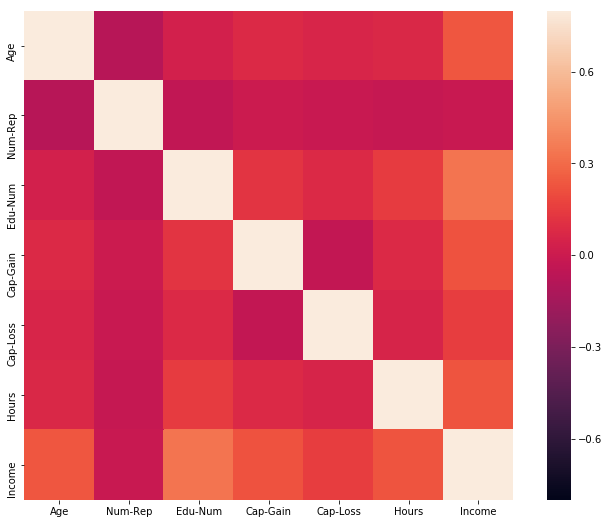

In [68]:
fcorr = test_features[['Age','Num-Rep','Edu-Num','Cap-Gain','Cap-Loss','Hours','Income']].corr()
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

It seems I was right about Num-Rep not being a good variable to use for PCA. Cap-Loss also seems like it might not have enough correlation between it and income, but I'll include it.

That leaves me with 6 possible features: __Age__, __Edu-Num__, __Sex__, __Cap-Gain__, __Cap-Loss__, and __Hours__.  This may not be enough. 

# Creating New Features

I can create possible features using the unused categorical census data.

## Type of Employeer

We will test all 8 categories of employeer presented in the census data. Private company employeers will be reprsented by __Private__. Self employed subjects without incorporation will be __Self-Emp__ and with incorporation will be __Self-Emp-Inc__. Subjects employeed by Federal, Local, and State goverment bodies will be classified as __Federal-Gov__, __Local-Gov__, and __State-Gov__ respectively. People who work for non-profits will be __Volunteer__ while people who've never worked in their life will be under __Never-Worked__.

In [69]:
test_features['Private'] = np.where((census['Employeer'].isin([' Private'])), 1, 0)
test_features['Self-Emp'] = np.where((census['Employeer'].isin([' Self-emp-not-inc'])), 1, 0)
test_features['Self-Emp-Inc'] = np.where((census['Employeer'].isin([' Self-emp-inc'])), 1, 0)
test_features['Federal-Gov'] = np.where((census['Employeer'].isin([' Federal-gov'])), 1, 0)
test_features['Local-Gov'] = np.where((census['Employeer'].isin([' Local-gov'])), 1, 0)
test_features['State-Gov'] = np.where((census['Employeer'].isin([' State-gov'])), 1, 0)
test_features['Volunteer'] = np.where((census['Employeer'].isin([' Without-pay'])), 1, 0)
test_features['Never-Worked'] = np.where((census['Employeer'].isin([' Never-worked'])), 1, 0)


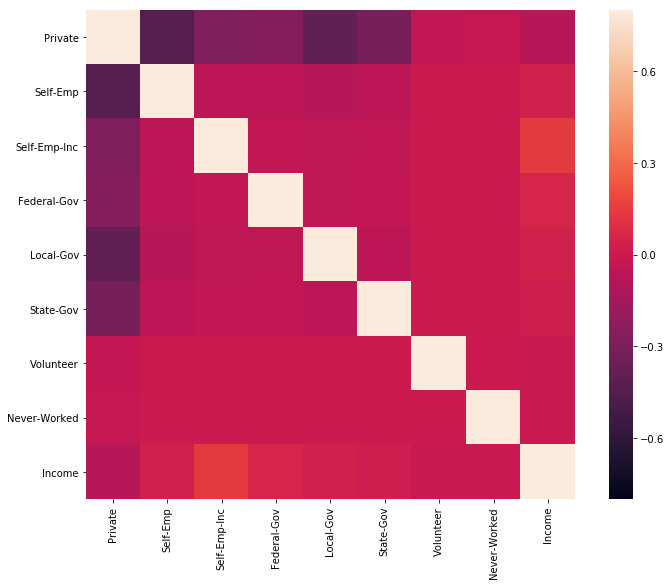

In [70]:
fcorr = test_features[['Private','Self-Emp','Self-Emp-Inc','Federal-Gov','Local-Gov',
                       'State-Gov','Volunteer','Never-Worked','Income']].corr()
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

I'll inlcude __Self-Emp_Inc__, the feature which decribes if a subject is both self-employeed and incorporated, since it appears to have a high correlation. __Self-Emp__ and __Fed-Gov__ also have a non-zero correlation, but are too low to include.

## Type of Job

The types of jobs represented here are extremely varied and the categories are self-explanitory.

In [71]:
test_features['Tech-support'] = np.where((census['Job'].isin([' Tech-support'])), 1, 0)
test_features['Craft-repair'] = np.where((census['Job'].isin([' Craft-repair'])), 1, 0)
test_features['Other-service'] = np.where((census['Job'].isin([' Other-service'])), 1, 0)
test_features['Exec-managerial'] = np.where((census['Job'].isin([' Exec-managerial'])), 1, 0)
test_features['Prof-specialty'] = np.where((census['Job'].isin([' Prof-specialty'])), 1, 0)
test_features['Handlers-cleaners'] = np.where((census['Job'].isin([' Handlers-cleaners'])), 1, 0)
test_features['Machine-op-inspct'] = np.where((census['Job'].isin([' Machine-op-inspct'])), 1, 0)
test_features['Adm-clerical'] = np.where((census['Job'].isin([' Adm-clerical'])), 1, 0)
test_features['Farming-fishing'] = np.where((census['Job'].isin([' Farming-fishing'])), 1, 0)
test_features['Transport-moving'] = np.where((census['Job'].isin([' Transport-moving'])), 1, 0)
test_features['Priv-house-serv'] = np.where((census['Job'].isin([' Priv-house-serv'])), 1, 0)
test_features['Protective-serv'] = np.where((census['Job'].isin([' Protective-serv'])), 1, 0)
test_features['Armed-Forces'] = np.where((census['Job'].isin([' Armed-Forces'])), 1, 0)

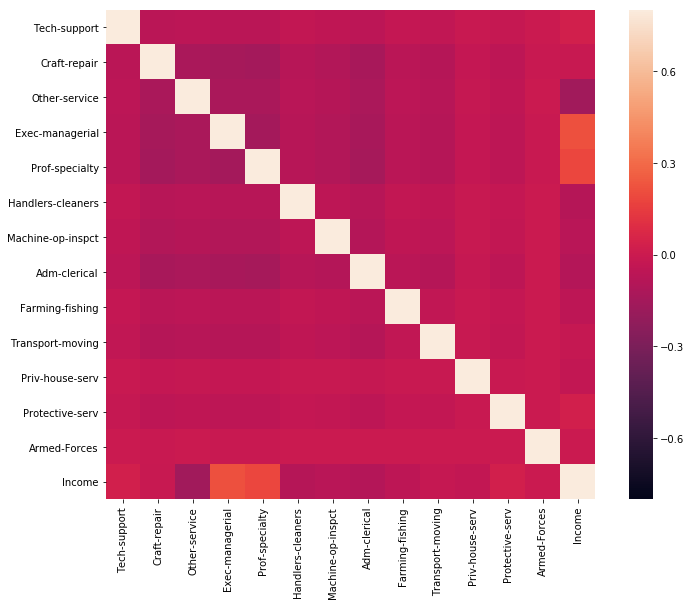

In [72]:
fcorr = test_features[['Tech-support','Craft-repair','Other-service','Exec-managerial','Prof-specialty',
                       'Handlers-cleaners','Machine-op-inspct','Adm-clerical','Farming-fishing','Transport-moving',
                       'Priv-house-serv','Protective-serv','Armed-Forces','Income']].corr()
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

I'll add __Exec-managerial__ and __Prof-speciality__ to the list of possible features. __Other-service__ should also be added as it correlates negatively with the outcome.

## Marital Status

Next, I'll look for features in the subject's marital status.

In [73]:
test_features['Never-Married'] = np.where((census['Marital'].isin([' Never-married'])), 1, 0)
test_features['Married'] = np.where((census['Marital'].isin([' Married-AF-spouse',' Married-civ-spouse'])), 1, 0)
test_features['Not-Married'] = np.where((census['Marital'].isin([' Separated',' Widowed',' Divorced'])), 1, 0)
test_features['Widowed'] = np.where((census['Marital'].isin([' Widowed'])), 1, 0)
test_features['Divorced'] = np.where((census['Marital'].isin([' Divorced'])), 1, 0)

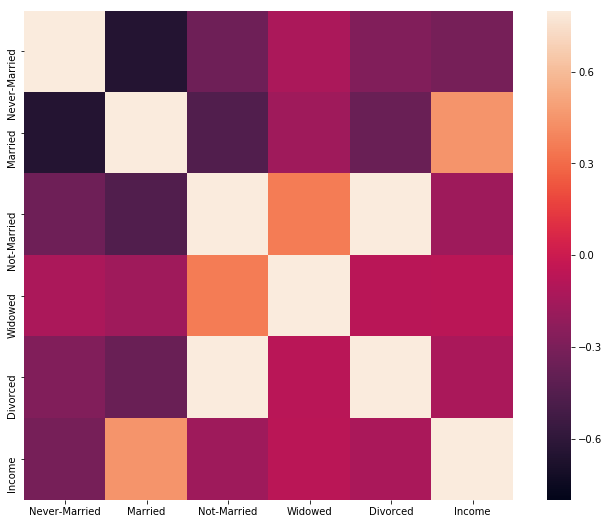

In [74]:
fcorr = test_features[['Never-Married','Married','Not-Married','Widowed','Divorced','Income']].corr()
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

__Married__ seems to be very strongly correlated with the outcome so I will definitely add it. On the other hand __Never-Married__ has a strong negative correlation while __Not-Married__ and __Divorced__ have a weak but present negative correlation.  However, because Married and Never-Married have such strong negative correlation, I will only only add __Married__, and because Divorced is a subgroup of Not-Married, I will only add __Not-Married__.

## Race

I'll see if there is any correlation between income being more or less than $50K and race.

In [75]:
test_features['White'] = np.where((census['Race'].isin([' White'])), 1, 0)
test_features['Asian'] = np.where((census['Race'].isin([' Asian-Pac-Islander'])), 1, 0)
test_features['Black'] = np.where((census['Race'].isin([' Black'])), 1, 0)
test_features['Amer-Indian'] = np.where((census['Race'].isin([' Amer-Indian-Eskimo'])), 1, 0)
test_features['Other'] = np.where((census['Race'].isin([' Other'])), 1, 0)

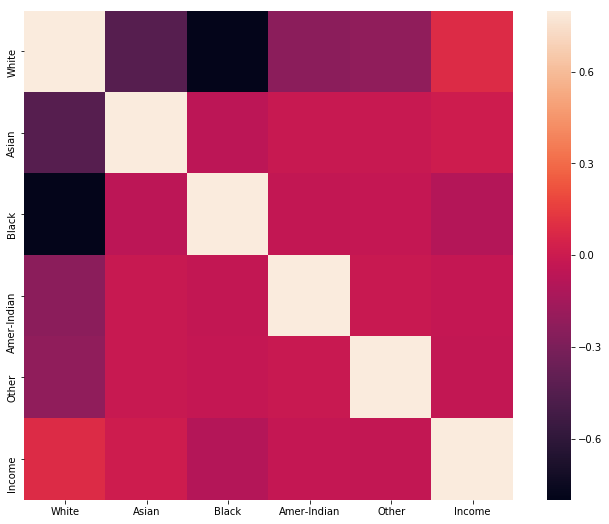

In [76]:
fcorr = test_features[['White','Asian','Black','Amer-Indian','Other','Income']].corr()
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

Interestingly, the correlation between income and race is not very strong. I will include __Black__, which had a very weak negative correlation to the outcome.

## Nationality

This is a tricky one to look at because of the fact that so many countries are respresented here and not many of them have many entries. To get around this, I'll group the countries together based on geographic location, political connections, and number represented in the sample.

In [77]:
census['Nationality'].value_counts()

 United-States                 29169
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

I will omit respondants who did not know their country of origin.

There will be 9 groups: __United States__ is the biggest group, no need to merge with other groups. __SE Asia__ will include Cambodia, Laos, the Philippines, Thailand, and Vietnam. __Brittish-Commonwealth__ will include Canada, England, India, Ireland, and Scotland. __China__ will include China, Hong, and Taiwan. __South-America__ will include Columbia, Ecudor, El Salvador, and Peru. __Latin-America__, or Central America, will include the Dominican Rebuplic, Guatemala, Haiti, Honduras, Jamaica, Mexico, Nicaragua, US Territories (e.g. Guam), Puerto-Rico, and Trinadad & Tobago. __W-Euro__ will include France, Germany, the Netherlands, and Italy. __E-Euro__ will include Greece, Hungary, Poland, Portugal, Yugoslavia, and Southern Europe. __Other__ will include uncharacterized nations: Cuba, Iran, and Japan. 

In [78]:
test_features['United States'] = np.where((census['Nationality'].isin([' United-States'])), 1, 0)

test_features['SE-Asia'] = np.where((census['Nationality'].isin([' Cambodia',' Laos',' Philippines',' Thailand',
                                                                 ' Vietnam'])), 1, 0)

test_features['British-Commonwealth'] = np.where((census['Nationality'].isin([' Canada',' England',' India',' Ireland',
                                                                             ' Scotland'])), 1, 0)

test_features['China'] = np.where((census['Nationality'].isin([' China',' Hong',' Taiwan'])), 1, 0)

test_features['South-America'] = np.where((census['Nationality'].isin([' Columbia',' Ecuador',' El-Salvador',' Peru'])), 1, 0)

test_features['Latin-America'] = np.where((census['Nationality'].isin([' Dominican-Republic',' Guatemala',' Haiti',
                                                                       ' Honduras',' Jamaica',' Mexico',' Nicaragua',
                                                                      ' Outlying-US(Guam-USVI-etc)',' Puerto-Rico',
                                                                      ' Trinadad&Tobago'])), 1, 0)

test_features['W-Euro'] = np.where((census['Nationality'].isin([' France',' Germany',' Holand-Netherlands',' Italy'])), 1, 0)

test_features['E-Euro'] = np.where((census['Nationality'].isin([' Greece',' Hungary',' Poland',' Portugal',' South',
                                                               ' Yugoslavia'])), 1, 0)

test_features['Other'] = np.where((census['Nationality'].isin([' Cuba',' Iran',' Japan'])), 1, 0)

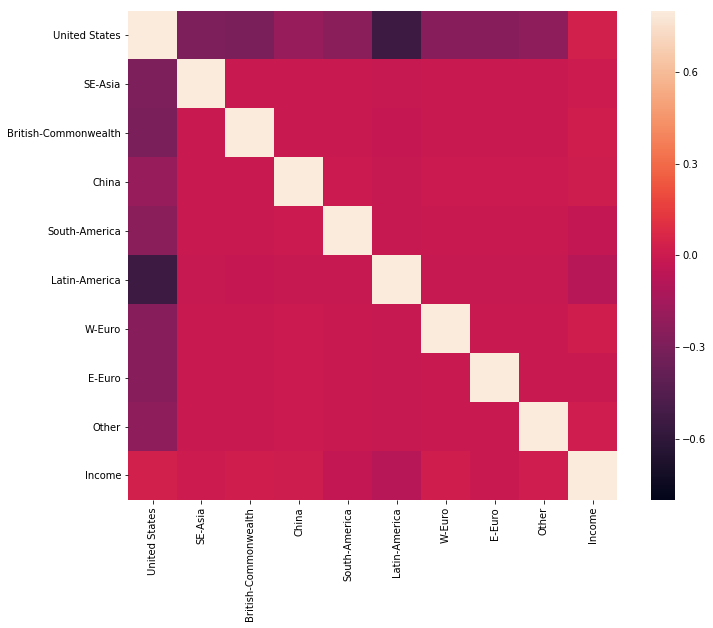

In [79]:
fcorr = test_features[['United States','SE-Asia','British-Commonwealth','China','South-America','Latin-America',
                       'W-Euro','E-Euro','Other','Income']].corr()
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

No nationality in particular seems to skew towards the outcome. However, the __Latin-America__ region tends to slightly skew away from the outcome, so we will include it.

## Finalizing Our Features

I'm ready to create a dataframe containing all the best features from the data.

In [80]:
x = ['Age','Edu-Num','Sex','Cap-Gain','Cap-Loss','Hours','Self-Emp-Inc','Exec-managerial','Prof-specialty',
     'Other-service','Married','Not-Married','Black','Latin-America']


features = test_features.loc[:, x+['Income']]
features.head()



,Age,Edu-Num,Sex,Cap-Gain,Cap-Loss,Hours,Self-Emp-Inc,Exec-managerial,Prof-specialty,Other-service,Married,Not-Married,Black,Latin-America,Income
0,50,13,1,0,0,13,0,1,0,0,1,0,0,0,0
1,38,9,1,0,0,40,0,0,0,0,0,1,0,0,0
2,53,7,1,0,0,40,0,0,0,0,1,0,1,0,0
3,28,13,0,0,0,40,0,0,1,0,1,0,1,0,0
4,37,14,0,0,0,40,0,1,0,0,1,0,0,0,0


Now I'll look at all the features I've created and pick the five best ones to use. I'll make a heatmap, this time only taking into

,Age,Edu-Num,Sex,Cap-Gain,Cap-Loss,Hours,Self-Emp-Inc,Exec-managerial,Prof-specialty,Other-service,Married,Not-Married,Black,Latin-America,Income
Age,1.000000,0.036527,0.088832,0.077674,0.057775,0.068756,0.102693,0.099353,0.054171,0.089346,0.315014,0.230674,0.019434,0.050791,0.234039
Edu-Num,0.036527,1.000000,0.012256,0.122627,0.079932,0.148127,0.077366,0.200941,0.419028,0.169676,0.086155,0.060157,0.075262,0.223286,0.335182
Sex,0.088832,0.012256,1.000000,0.048477,0.045572,0.229312,0.084020,0.036738,0.028503,0.153671,0.430949,0.325818,0.115599,0.003461,0.215995
Cap-Gain,0.077674,0.122627,0.048477,1.000000,0.031614,0.078409,0.096886,0.060620,0.085224,0.040269,0.085745,0.027216,0.020630,0.017487,0.223333
Cap-Loss,0.057775,0.079932,0.045572,0.031614,1.000000,0.054256,0.031713,0.048308,0.046253,0.040849,0.080145,0.026448,0.021765,0.024234,0.150523
Hours,0.068756,0.148127,0.229312,0.078409,0.054256,1.000000,0.127868,0.139208,0.060253,0.155873,0.212874,0.031025,0.053153,0.010364,0.229690
Self-Emp-Inc,0.102693,0.077366,0.084020,0.096886,0.031713,0.127868,1.000000,0.133094,0.009172,0.048102,0.109359,0.030667,0.048190,0.021121,0.139464
Exec-managerial,0.099353,0.200941,0.036738,0.060620,0.048308,0.139208,0.133094,1.000000,0.144177,0.126754,0.106608,0.003688,0.046092,0.048867,0.214856
Prof-specialty,0.054171,0.419028,0.028503,0.085224,0.046253,0.060253,0.009172,0.144177,1.000000,0.128068,0.041038,0.021155,0.049525,0.047209,0.185861
Other-service,0.089346,0.169676,0.153671,0.040269,0.040849,0.155873,0.048102,0.126754,0.128068,1.000000,0.161577,0.054684,0.088122,0.054255,0.156355


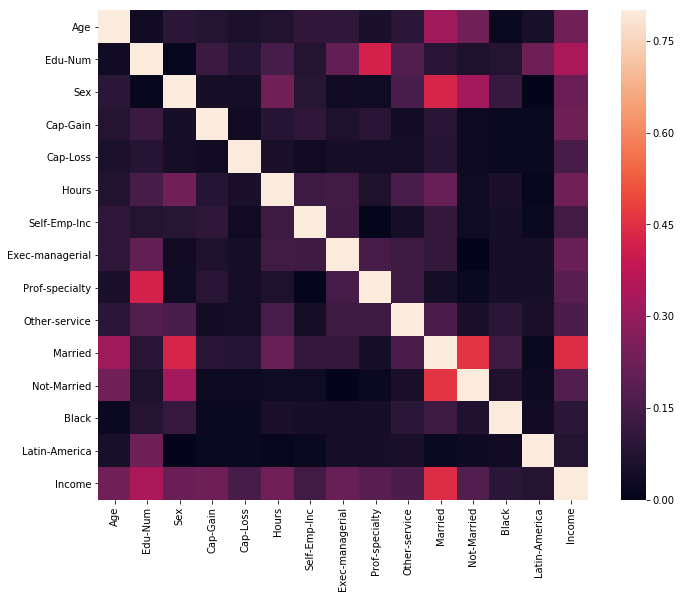

In [81]:
fcorr = abs(features.corr())

display(fcorr)

f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=0, square=True)
plt.show()

Looking at the heatmap of their correlation, I can definitely tell I will keep __Married__ and __Edu-Num__ as they both have significantly higher correlation than other features. From there, it looks to be a toss up between Age, Sex, Cap-Gain, Hours, and Exec-managerial columns.  Let's look at the correlations of these 5 columns and Income.

In [82]:
fcorr2 = abs(features[['Age','Sex','Cap-Gain','Hours','Exec-managerial','Income']].corr())

display(fcorr2)

,Age,Sex,Cap-Gain,Hours,Exec-managerial,Income
Age,1.000000,0.088832,0.077674,0.068756,0.099353,0.234039
Sex,0.088832,1.000000,0.048477,0.229312,0.036738,0.215995
Cap-Gain,0.077674,0.048477,1.000000,0.078409,0.060620,0.223333
Hours,0.068756,0.229312,0.078409,1.000000,0.139208,0.229690
Exec-managerial,0.099353,0.036738,0.060620,0.139208,1.000000,0.214856
Income,0.234039,0.215995,0.223333,0.229690,0.214856,1.000000


They are all fairly close, but if we have to narrow it down to 5, or 3 from these, we should pick __Age__, __Hours__, and __Cap-Gain__ since they correlation slightly more with the outcome than the other 2.

So the five best features are: a binary categorical value for marriage status, __Married__, a continuous value representing higest education, __Edu-Num__, a continuous value equal to __Age__, a continous value equal to number of hours, and a continuous value for captial gain amount, __Cap-Gain__.

# Performing PCA

Now that I have chosen some more possible features, I am ready to begin the Principal Compoment Analysis of my dataset.

In [83]:
target = census.loc[:, ['Income']].values
target_df = pd.DataFrame(target, columns=['Income'])

features_std = StandardScaler().fit_transform(features.loc[:, x].values)

c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [84]:
cov_matrix = np.cov(features_std, rowvar=False)

print('Covariance matrix of X: \n%s' %cov_matrix)

Covariance matrix of X: 
[[ 1.00003071  0.03652797  0.08883447  0.07767677  0.05777656  0.06875785
   0.10269569  0.09935576  0.05417245 -0.08934825  0.31502364  0.23068099
  -0.01943435 -0.05079303]
 [ 0.03652797  1.00003071  0.01225626  0.12263117  0.0799346   0.14813145
   0.07736864  0.20094686  0.4190409  -0.16968152  0.08615737 -0.06015844
  -0.07526459 -0.22329318]
 [ 0.08883447  0.01225626  1.00003071  0.04847831  0.04557381  0.2293187
   0.08402261  0.03673876 -0.02850417 -0.1536762   0.43096179 -0.32582827
  -0.11560207  0.00346086]
 [ 0.07767677  0.12263117  0.04847831  1.00003071 -0.03161508  0.07841121
   0.09688866  0.06062182  0.08522692 -0.04027046  0.08574734 -0.02721698
  -0.02063031 -0.01748744]
 [ 0.05777656  0.0799346   0.04557381 -0.03161508  1.00003071  0.05425783
   0.03171405  0.04830973  0.04625426 -0.04085033  0.0801477  -0.02644893
  -0.02176535 -0.02423451]
 [ 0.06875785  0.14813145  0.2293187   0.07841121  0.05425783  1.00003071
   0.12787238  0.13921226  

In [85]:
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)

print('Eigenvectors of Cov(X): \n%s' %eigenvectors)

print('\nEigenvalues of Cov(X): \n%s' %eigenvalues)

Eigenvectors of Cov(X): 
[[-0.2047146  -0.14466169 -0.47442877 -0.07837157 -0.50452257 -0.05221701
   0.58388353  0.1397399   0.10362337  0.15224967 -0.06464103 -0.04259559
  -0.1903528   0.10990224]
 [-0.28829138 -0.50726041  0.01386516 -0.65837957  0.26050652  0.1779168
  -0.16576853  0.26157194 -0.0045857   0.12622611 -0.04739408 -0.04868573
   0.05116135  0.08552125]
 [-0.40023269  0.35377705 -0.03017081  0.04801378  0.03521863  0.79887234
   0.08146528 -0.04908676  0.02323534 -0.17877303  0.1333708  -0.09802476
  -0.04954396 -0.02460945]
 [-0.16348115 -0.1489507   0.00445623  0.0182128  -0.05966885 -0.00699463
   0.06138998 -0.27552208 -0.66164179 -0.3904108  -0.47211332  0.11000898
  -0.001529    0.205572  ]
 [-0.12319219 -0.0675532  -0.0043807   0.01303656 -0.02591614  0.003324
   0.05663999 -0.21558726  0.57973944 -0.2337557  -0.22703746  0.35562293
   0.54488955  0.25307036]
 [-0.31996059 -0.04132915 -0.12059369  0.02103492 -0.15170864 -0.31123458
  -0.09701835  0.27269194 -0.

In [86]:
# Make a set of (eigenvalue, eigenvector) pairs
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()
eig_pairs.reverse()

# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sort = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

# Let's confirm our sorting worked, print out eigenvalues
print('Eigenvalues in descending order: \n%s' %eigvalues_sort)

Eigenvalues in descending order: 
[2.257638103747045, 1.5614673974589717, 1.3003303922607432, 1.0830221807660019, 1.0508177484899885, 0.9822507564587211, 0.9677780459523841, 0.9424041875696465, 0.8744640562141575, 0.8406553304479457, 0.800812395793498, 0.5889811252569446, 0.44258462569534807, 0.3072236425246272]


Cumulative proportion of variance explained vector: 
[0.16125491 0.27278487 0.36566276 0.44301911 0.51807522 0.58823383
 0.65735871 0.72467123 0.78713103 0.84717599 0.90437512 0.94644391
 0.97805613 1.        ]


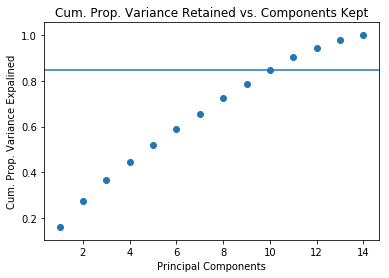

In [87]:
# Find cumulative variance of each principle component
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)

plt.title('Cum. Prop. Variance Retained vs. Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')
plt.axhline(y=.85)
plt.scatter(num_comp, var_comp_sum)

plt.show()

## Running and Visualizing our PCA

In [88]:
from sklearn.decomposition import PCA
n=10
pca = PCA(n_components=n)
c=[]
for i in range(n):
    c.append('Component {}'.format(i+1))
principalComponents = pca.fit_transform(features_std)
principalDf = pd.DataFrame(data = principalComponents,columns = c)

finalDf = pd.concat([principalDf, test_features[['Income']]], axis = 1)
display(finalDf.head())

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Income
0,1.320100,0.057167,0.697480,-0.975418,-0.647841,-1.274735,0.928210,-0.217101,1.946175,-2.183122,0
1,-0.971575,0.459925,0.833675,0.307711,-0.276513,-0.517756,-0.982557,-0.033095,-0.427763,0.821349,0
2,0.136505,-1.357289,0.793909,1.330704,0.113670,0.753032,1.478690,-2.523484,-0.431443,-0.476430,0
3,0.081961,1.617741,-2.018218,0.732491,0.644654,1.767142,1.272183,-2.174676,-0.415925,-1.389996,0
4,1.086062,0.958757,0.521979,-1.981617,-0.325801,-0.308787,0.200068,-0.396259,1.398047,-1.249468,0


In [89]:
finalDf = pd.concat([principalDf, test_features[['Income']]], axis = 1)
display(finalDf.head())

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Income
0,1.320100,0.057167,0.697480,-0.975418,-0.647841,-1.274735,0.928210,-0.217101,1.946175,-2.183122,0
1,-0.971575,0.459925,0.833675,0.307711,-0.276513,-0.517756,-0.982557,-0.033095,-0.427763,0.821349,0
2,0.136505,-1.357289,0.793909,1.330704,0.113670,0.753032,1.478690,-2.523484,-0.431443,-0.476430,0
3,0.081961,1.617741,-2.018218,0.732491,0.644654,1.767142,1.272183,-2.174676,-0.415925,-1.389996,0
4,1.086062,0.958757,0.521979,-1.981617,-0.325801,-0.308787,0.200068,-0.396259,1.398047,-1.249468,0


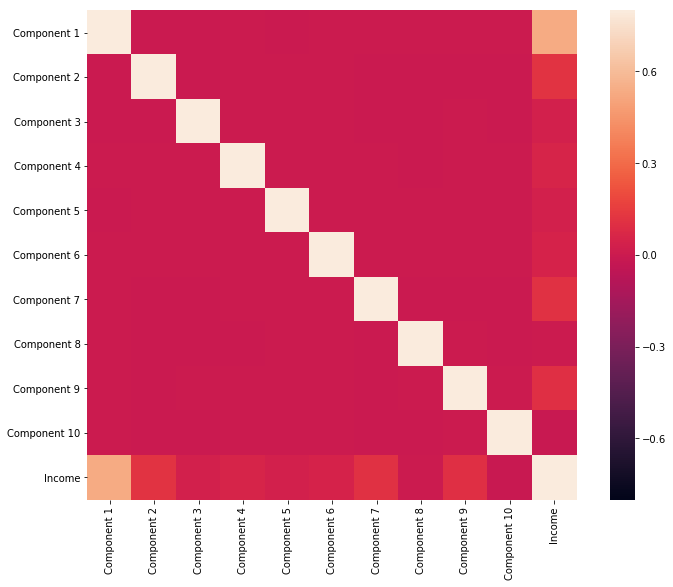

In [90]:
fcorr = finalDf.corr()
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(fcorr, vmax=.8, vmin=-0.8, square=True)
plt.show()

# Testing our Prediction

## References

http://archive.ics.uci.edu/ml/datasets/Adult